Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [263]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from random import random, randint, shuffle, seed, choice, sample
from scipy import sparse
from copy import copy
from functools import reduce
from sklearn.metrics.pairwise import cosine_similarity

In [264]:
def make_set_covering_problem(num_points, num_sets, density):
    """Returns a sparse array where rows are sets and columns are the covered items"""
    seed(num_points * 2654435761 + num_sets + density)
    sets = sparse.lil_array((num_sets, num_points), dtype = bool)
    for s, p in product(range(num_sets), range(num_points)):
        if random() < density:
            sets[s, p] = True
    for p in range(num_points):
        sets[randint(0, num_sets - 1), p] = True
    return sets

# Halloween Challenge

Find the best solution with the fewest calls to the fitness functions for:

* `num_points = [100, 1_000, 5_000]`
* `num_sets = num_points`
* `density = [.3, .7]` 

In [265]:
n = 100
PROBLEM_SIZE = NUM_SETS = n
x = make_set_covering_problem(n, n, .3)

SETS = x.toarray()
print("Element at row=42 and column=42:", x[1, 1])

Element at row=42 and column=42: False


# Our Solution

## Cluster Random Cosine (100, 0.3)

In [267]:
similarity_matrix = cosine_similarity(SETS * 1)

In [ ]:
sns.set()  
plt.figure(figsize=(8, 6))

sns.heatmap(similarity_matrix, cmap="YlGnBu", annot = False, square=True, cbar=True, xticklabels=False, yticklabels=False)

plt.xlabel("Sets")
plt.ylabel("Sets")

plt.show()

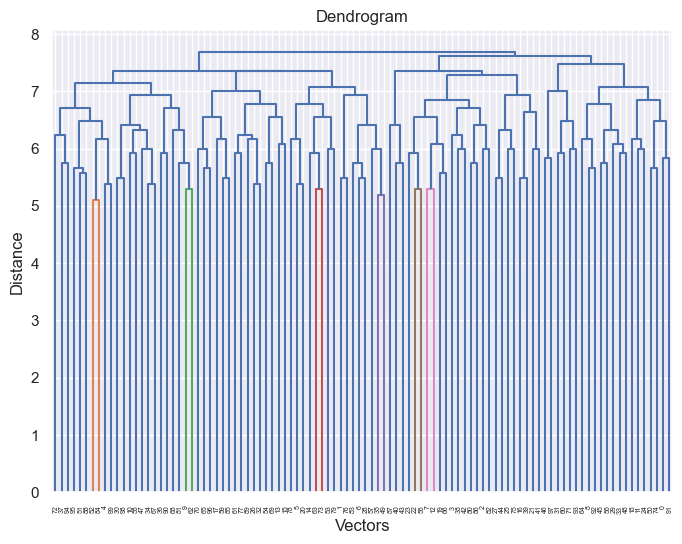

In [268]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns

# Example matrix of vectors (each row is a vector)
matrix = SETS * 1

# Calculate cosine similarity
similarity_matrix = cosine_similarity(matrix)

# Perform hierarchical clustering
linkage_matrix = linkage(matrix, method = 'complete')  # 1 - similarity for distance

# Plot the dendrogram (optional)
plt.figure(figsize=(8, 6))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Vectors')
plt.ylabel('Distance')
plt.show()

# Cut the dendrogram to get clusters
threshold = 7  # Set a threshold for similarity
clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# Print the clusters
# for vector, cluster in enumerate(clusters):
#     print(f"Vector {vector + 1} is in Cluster {cluster}")


In [269]:
# TRADE-OFF between cost and number of calls (0.3 density)
threshold = 6.4   # missing_steps = 50    # n = 100
# threshold = 21.4  missing_steps = 50    # n = 1000
# threshold = 47    missing_steps = 100   # n = 5000 <(5000, -16), 898>

clusters = fcluster(linkage_matrix, threshold, criterion='distance')

(array([12., 11., 13.,  8., 10.,  6., 11.,  8.,  9., 12.]),
 array([ 1. ,  4.5,  8. , 11.5, 15. , 18.5, 22. , 25.5, 29. , 32.5, 36. ]),
 <BarContainer object of 10 artists>)

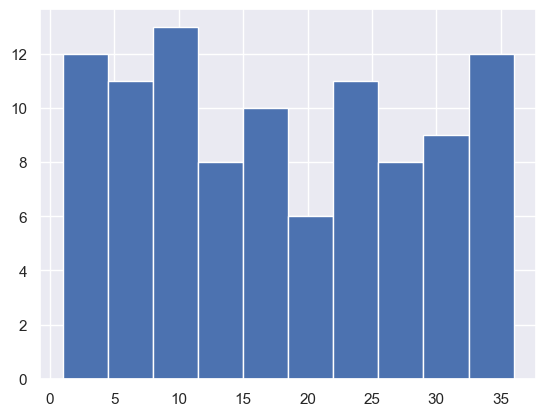

In [270]:
plt.hist(clusters, bins = 10)

In [271]:
from random import choice

dict_cluster_set = {clusters[i]:[] for i in range(PROBLEM_SIZE)}

for set in range(len(clusters)):

    dict_cluster_set[clusters[set]].append(set)


def tweak(state):
    new_state = copy(state)
    candidates = []
    selected = []
    for cluster in dict_cluster_set.keys():
        chosen_one = choice(dict_cluster_set[cluster])
        selected.append(chosen_one)
        candidates.append(SETS[chosen_one])


    return candidates, selected

In [272]:
temp = [False for _ in range(PROBLEM_SIZE)]
cand, chos = tweak(temp)

In [273]:
def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

def tweak(state, index):
    new_state = copy(state)
    new_state[index] = not new_state[index]
    return new_state

In [277]:
current_state = [False for _ in range(PROBLEM_SIZE)]
candidate_state = current_state
flag = False

print(fitness2(current_state))
count_fitness = 0
best_index = 0
missing_steps = 0

for step in range(10000):
    
    candidates = []
    selected = []
       
    for cluster in dict_cluster_set.keys():
        chosen_one = choice(dict_cluster_set[cluster])
        selected.append(chosen_one)
        candidates.append(SETS[chosen_one])
    
    for i in range(len(candidates)):
        
        new_state = tweak(current_state, chos[i])
        
        count_fitness += 1
        if fitness2(new_state) > fitness2(candidate_state):
            candidate_state = new_state
            best_index = i
            print(step, count_fitness, fitness2(candidate_state))
            missing_steps = 0
        else:
            missing_steps += 1
    
        if missing_steps == 50:
            flag = True
            break
        
    
    if flag:
        break

    current_state = candidate_state   

print(fitness2(current_state))

print(count_fitness)

(0, 0)
0 1 (29, -1)
0 2 (42, -1)
1 37 (59, -2)
1 39 (62, -2)
1 40 (67, -2)
1 72 (68, -2)
2 73 (80, -3)
2 84 (84, -3)
3 109 (89, -4)
3 111 (90, -4)
3 128 (91, -4)
4 145 (93, -5)
4 147 (95, -5)
4 159 (96, -5)
5 181 (97, -6)
5 183 (98, -6)
6 217 (99, -7)
7 257 (100, -8)
(100, -8)
307


## Baseline

In [219]:
def tweak(state):
    new_state = copy(state)
    index = randint(0, PROBLEM_SIZE - 1)
    new_state[index] = not new_state[index]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

In [223]:
current_state = [False for _ in range(PROBLEM_SIZE)]
print(fitness2(current_state))
count_fitness = 1
count_updates = 0
missing_steps = 0

for step in range(100_000):
    new_state = tweak(current_state)
    count_fitness += 1
    if fitness2(new_state) > fitness2(current_state):
        current_state = new_state
        count_updates += 1
        print(fitness2(current_state))
        missing_steps = 0
    else:
        missing_steps += 1
    
    if missing_steps == 1000:
        break
        
print('Count Fitness:', count_fitness)
print('Count Updates:', count_updates)

(0, 0)
(1513, -1)
(2548, -2)
(3258, -3)
(3790, -4)
(4167, -5)
(4405, -6)
(4600, -7)
(4703, -8)
(4784, -9)
(4842, -10)
(4892, -11)
(4923, -12)
(4946, -13)
(4956, -14)
(4964, -15)
(4972, -16)
(4978, -17)
(4986, -18)
(4990, -19)
(4992, -20)
(4994, -21)
(4995, -22)
(4997, -23)
(4998, -24)
(4999, -25)
(5000, -26)
(5000, -25)
(5000, -24)
(5000, -23)
(5000, -22)
Count Fitness: 2831
Count Updates: 30


In [ ]:
# multiple experiments with different initial states
for i, elem in enumerate(initial_states):
    print(f'Initial state {i}')
    current_state = copy(elem)
    #print(current_state)
    #print(fitness2(current_state))
    count_fitness = 0
    for step in range(10_000):
        new_state = tweak(current_state)
        if fitness2(new_state) > fitness2(current_state):
            current_state = new_state
            count_fitness += 1
            #print(fitness2(current_state))
    print("final state fitness ", fitness2(current_state))
    print("count_fitness: ", count_fitness)
    print("End of iteration number ", i)
    print()

### Random N-1 Tweaking

In [547]:
def tweak(state):
    new_state = copy(state)
    n_swapping = randint(0, PROBLEM_SIZE - 1)
    index_list = sample(range(0, PROBLEM_SIZE - 1), n_swapping)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

In [548]:
current_state = [False for _ in range(PROBLEM_SIZE)]
print(current_state)
print(fitness2(current_state))
count_fitness = 0
count_updates = 0
missing_steps = 0

for step in range(10_000):
    new_state = tweak(current_state)
    count_fitness += 2
    if fitness2(new_state) > fitness2(current_state):
        current_state = new_state
        count_updates += 1
        print(fitness2(current_state))
        missing_steps = 0
    else:
        missing_steps += 1
    
    if missing_steps == 2000:
        break
        
print('Count Fitness:', count_fitness)
print('Count Updates:', count_updates)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

KeyboardInterrupt: 

### Random 2 Tweak

In [549]:
def tweak(state):
    new_state = copy(state)
    index_list = sample(range(0, PROBLEM_SIZE - 1), 2)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

In [552]:
current_state = [False for _ in range(PROBLEM_SIZE)]
print(fitness2(current_state))
count_fitness = 0
count_updates = 0
missing_steps = 0

for step in range(10_000):

    new_state = tweak(current_state)
    count_fitness += 2
    if fitness2(new_state) > fitness2(current_state):
        current_state = new_state
        print(fitness2(current_state))
        count_updates += 1
        missing_steps = 0
    else:
        missing_steps += 1

    if missing_steps == 1000:
        break
    
print(count_fitness)
print('Count Fitness:', count_fitness)
print('Count Updates:', count_updates)

(0, 0)
(912, -2)
(997, -4)
(1000, -6)
2006
Count Fitness: 2006
Count Updates: 3


### Random 3 tweak

In [553]:
def tweak(state):
    new_state = copy(state)
    index_list = sample(range(0, PROBLEM_SIZE - 1), 3)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

In [554]:
current_state = [False for _ in range(PROBLEM_SIZE)]

print(fitness2(current_state))
count_fitness = 0
count_updates = 0
missing_steps = 0

for step in range(10_000):
    new_state = tweak(current_state)
    count_fitness += 2
    if fitness2(new_state) > fitness2(current_state):
        current_state = new_state
        print(fitness2(current_state))
        count_updates += 1
        missing_steps = 0
    else:
        missing_steps += 1
    
    if missing_steps == 1000:
        break

print(count_fitness)
print('Count Fitness:', count_fitness)
print('Count Updates:', count_updates)

(0, 0)
(973, -3)
(999, -6)
(1000, -9)
2006
Count Fitness: 2006
Count Updates: 3


In [ ]:
def simulated_annealing(current_state, new_state, temperature):

    return np.exp(-(fitness2(current_state)[1] - fitness2(new_state)[1])/(temperature + 0.0001))

def tweak(state):
    new_state = copy(state)
    index_list = sample(range(0, PROBLEM_SIZE - 1), 2)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost


In [ ]:
current_state = [False for _ in range(PROBLEM_SIZE)]

temperature = 0.01
print(fitness2(current_state))
count_fitness = 0
for step in range(10_000):

    new_state = tweak(current_state)
    temperature = temperature * 0.5 if step % 100 == 0 else temperature

    if fitness2(new_state) > fitness2(current_state):

        current_state = new_state
        print(fitness2(current_state))
        count_fitness += 1
    
    else:
        
        p = simulated_annealing(current_state, new_state, temperature)
        
        if random() < p:
        
            current_state = new_state
            print("SA:", fitness2(current_state))
            count_fitness += 1

print(count_fitness)

# Steepest Ascent Hill Climbing (1 tweak)

In [216]:
def simulated_annealing(current_state, new_state, temperature):

    return np.exp(-(fitness2(current_state)[1] - fitness2(new_state)[1])/(temperature + 0.0001))

def tweak(state, index):
    new_state = copy(state)
    new_state[index] = not new_state[index]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost


In [217]:
current_state = [False for _ in range(PROBLEM_SIZE)]
candidate_state = current_state

print(fitness2(current_state))
count_fitness = 0
best_index = 0
for step in range(1000):
    for i in range(PROBLEM_SIZE):
        new_state = tweak(current_state, i)
        if fitness2(new_state) > fitness2(candidate_state):
            candidate_state = new_state
            best_index = i
            count_fitness += 1
            print(step, count_fitness, fitness2(candidate_state))

    current_state = candidate_state   

print(fitness2(current_state))

print(count_fitness)

(0, 0)
0 1 (1491, -1)
0 2 (1524, -1)
0 3 (1528, -1)
0 4 (1531, -1)
0 5 (1607, -1)
0 6 (1613, -1)
1 7 (2625, -2)
1 8 (2636, -2)
1 9 (2649, -2)
1 10 (2671, -2)
1 11 (2695, -2)
1 12 (2723, -2)


KeyboardInterrupt: 

# Steepest Stochastic Ascent Hill Climbing (2 tweak)

In [214]:
def simulated_annealing(current_state, new_state, temperature):
    return np.exp(-(fitness2(current_state)[1] - fitness2(new_state)[1])/(temperature + 0.0001))

def tweak(state, index_list):
    new_state = copy(state)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost


In [215]:
current_state = [False for _ in range(PROBLEM_SIZE)]
candidate_state = current_state
star_state = None
missing_steps = 0

print(fitness2(current_state))
count_fitness = 0
best_states = []
to_append = False

for step in range(1_000):
    candidate_state = current_state

    if missing_steps >= 5:
        if star_state is None or fitness2(star_state) > fitness2(star_state):
            star_state = copy(current_state)

        heavy_index_list = sample(range(0, PROBLEM_SIZE - 1), int(np.ceil(abs(fitness2(current_state)[1]/3))))
        print("Tried 5 times, no improvement...")
        current_state = [False for _ in range(PROBLEM_SIZE)]
        current_state = tweak(current_state, heavy_index_list) 
        candidate_state = current_state

        missing_steps = 0
        to_append = False

    for i in range(10_000):
        index_list = sample(range(0, PROBLEM_SIZE - 1), 2)
        new_state = tweak(current_state, index_list)
        if fitness2(new_state) > fitness2(candidate_state):
            missing_steps = 0
            candidate_state = new_state
            to_append = True
            print(step, fitness2(candidate_state))
        
    if current_state is not candidate_state:
        count_fitness += 1
        current_state = candidate_state
    else: 
        missing_steps += 1 

print("fitness_value:", fitness2(current_state)) if star_state is None else print("fitness_value:", fitness2(star_state))
print("count_fitness: ", count_fitness)

(0, 0)
0 (2625, -2)
0 (2628, -2)
0 (2635, -2)
0 (2637, -2)
0 (2651, -2)
0 (2669, -2)
0 (2683, -2)
0 (2689, -2)
1 (3894, -4)
1 (3902, -4)
1 (3928, -4)
1 (3932, -4)
1 (3939, -4)
1 (3947, -4)
1 (3956, -4)
2 (4486, -6)
2 (4506, -6)
2 (4510, -6)
2 (4515, -6)
2 (4523, -6)
2 (4539, -6)
2 (4541, -6)
2 (4547, -6)
3 (4791, -8)
3 (4792, -8)
3 (4796, -8)
3 (4797, -8)
3 (4805, -8)
3 (4808, -8)
3 (4811, -8)
3 (4816, -8)
4 (4930, -10)
4 (4931, -10)
4 (4933, -10)
4 (4934, -10)
5 (4976, -12)
5 (4979, -12)
5 (4980, -12)
5 (4982, -12)
5 (4984, -12)
6 (4993, -14)
6 (4995, -14)
6 (4996, -14)
6 (4997, -14)
6 (4998, -14)
6 (4999, -14)
7 (5000, -16)


KeyboardInterrupt: 